# Imports

In [1]:
from source.dataLoader import load_dataset
from source.utils import save_visualizations, save_results_to_csv, plot_all_categories_with_images
from source.train import train_model
from source.evaluate import evaluate_model 
from source.losses import mse_loss
from source.models import ADTR, ADTR_FPN
import config
import torch
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim import AdamW
import gc
import os
import kagglehub

/home/luca/Efficient-Anomaly-Detection-in-Industrial-Images/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download Datasets (if needed)

In [3]:
if not os.path.exists(config.MVTEC_ROOT) and config.DATASET_TO_USE == 'mvtec':
    dataset_path = kagglehub.dataset_download(config.MVTEC_KAGGLE_DOWNLOAD_URL)
elif not os.path.exists(config.BTAD_ROOT) and config.DATASET_TO_USE == 'batd':
    dataset_path = kagglehub.dataset_download(config.BTAD_KAGGLE_DOWNLOAD_URL)
    dataset_path += "/BTech_Dataset_transformed"

print(f"Dataset loaded")

Dataset loaded


# Clean cache

In [ ]:
def cleanup():
    print("\n--- Cleaning VRAM ---")

    try:
        del model
        del optimizer
        print("Deleted model and optimizer objects.")
    except NameError:
        print("Model and optimizer objects were not found for deletion (already deleted or out of scope).")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("PyTorch CUDA cache cleared.")

    gc.collect()
    print("Garbage collection triggered.")

    print("\nVRAM cleaning process complete.")

# Setup/Train/Evaluate model

In [ ]:
torch.manual_seed(config.RANDOM_SEED)

if config.DOWNLOAD_DATASET:
    DATASET = dataset_path
else:
    DATASET = config.MVTEC_ROOT if config.DATASET_TO_USE == 'mvtec' else config.BTAD_ROOT

transform_train = transforms.Compose([
    transforms.Resize(config.IMG_SIZE),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(config.IMG_SIZE),
    transforms.ToTensor(),
])

categories = config.MVTEC_CATEGORIES if config.DATASET_TO_USE == 'mvtec' else config.BTAD_CATEGORIES

for category in categories:
    print(f"Processing category: {category}")
    
    # Load the dataset
    train_loader, test_loader = load_dataset(
        main_path=DATASET,
        transform_train=transform_train,
        transform_test=transform_test,
        class_selected=category,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS
    )

    print("Instantiate model, optimizer, scheduler, and loss function")
    # select model based on configuration
    if config.MODEL == 'ADTR_FPN':
        model = ADTR_FPN.ADTR_FPN(use_dyt=config.USE_DYT).to(config.DEVICE)
        optimizer = AdamW(model.reconstruction.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
        criterion = mse_loss
    elif config.MODEL == 'ADTR':
        model = ADTR.ADTR(use_dyt=config.USE_DYT).to(config.DEVICE)
        optimizer = AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
        scheduler = None
        criterion = mse_loss
    else:
        raise ValueError(f"Model {config.MODEL} is not supported.")

    if config.LOAD_WEIGHTS:
        print(f"Loading weights for {config.MODEL} in category {category}")
        # check if the checkpoint exists
        if not os.path.exists(f"{config.CHECKPOINT_DIR}/{config.MODEL}_{category}.pth"):
            raise FileNotFoundError(f"Checkpoint for {config.MODEL} in category {category} does not exist.")
        model.load_state_dict(torch.load(f"{config.CHECKPOINT_DIR}/{config.MODEL}_{category}.pth"))

    # Train the model
    if config.TRAIN_MODEL:
        train_model(model, train_loader, optimizer, criterion, config.DEVICE, config.EPOCHS, scheduler=scheduler)
        # Save the model
        model_save_path = os.path.join(config.CHECKPOINT_DIR, f"{config.MODEL}_{category}.pth")
        os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
        torch.save(model.state_dict(), model_save_path)

    # Evaluate the model
    image_auroc, pixel_auroc, precision, f1 = evaluate_model(model, test_loader, config.DEVICE)

    # Save visualizations
    path_images = save_visualizations(model, test_loader, category, config)
    
    save_results_to_csv(
        model_name=config.MODEL,
        category_name=category,
        image_auroc=image_auroc,
        pixel_auroc=pixel_auroc,
        precision=precision,
        f1=f1,
        path_images=path_images,
        save_dir=config.RESULT_FOLDER
    )
    
    cleanup()

INFO: Identified 'ok' as the normal sample folder.


Processing category: 01
Instantiate model, optimizer, scheduler, and loss function
Loading weights for ADTR in category 01


Evaluating: 100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Saving 8 visualization images to: images/ADTR


Generating and Saving Images: 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
INFO: Identified 'ok' as the normal sample folder.


Done.
Creating new results file for category '01' at 'results/ADTR/ADTR_results.csv'
Processing category: 02
Instantiate model, optimizer, scheduler, and loss function
Loading weights for ADTR in category 02


FileNotFoundError: Checkpoint for ADTR in category 02 does not exist.

# Plot Results

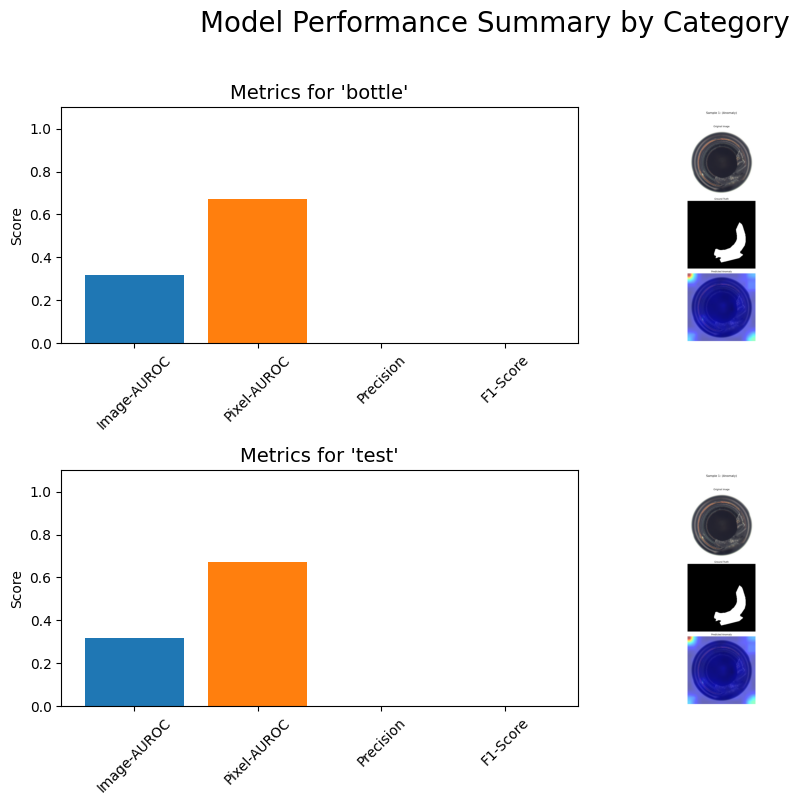

In [3]:
plot_all_categories_with_images(f"{config.RESULT_FOLDER}/{config.MODEL}_results.csv", img_to_plot=[], save_path=None)

# Delete Dataset

In [ ]:
if config.DOWNLOAD_DATASET and config.DELETE_CACHE_DATASET:
    # Delete KaggleHub cache to free up space
    print("\n--- Deleting KaggleHub cache ---")
    %rm -rf ~/.cache/kagglehub